In [1]:
import numpy as np
import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Add,
    Conv2D,
    Input,
    ReLU,
    MaxPool2D,
    UpSampling2D,
    BatchNormalization,
    Softmax,
    Lambda,
    Flatten,
    Dense,
)

In [2]:
_hg_first_layer_stride = 1
_hg_num_modules = 2
_hg_num_feature_maps = 32
_hg_num_landmarks = 18
_hg_num_residual_blocks = 1
_kernel_initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)
_kernel_regularizer = keras.regularizers.L2(1e-4)
_bias_initializer = keras.initializers.Zeros()

In [3]:
def build_rb(x, num_in, num_out):
    half_num_out = max(int(num_out/2), 1)

    # Lower branch
    c = x
    # Conv1
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=half_num_out,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(c)

    # Conv2
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=half_num_out,
        kernel_size=3,
        strides=1,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(c)

    # Conv3
    c = BatchNormalization(scale=True, center=True, trainable=True)(c)
    c = ReLU()(c)
    c = Conv2D(
        filters=num_out,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(c)

    # Upper branch
    s = x
    # Skip
    if num_in == num_out:
        s = tf.identity(s)
    else:
        s = Conv2D(
            filters=num_out,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer=_kernel_initializer,
            kernel_regularizer=_kernel_regularizer,
            bias_initializer=_bias_initializer
        )(s)
    x = Add()([c, s])
    return x

def build_hg(x, steps_to_go, num_features):
    # Upper branch
    up1 = x
    for i in range(_hg_num_residual_blocks):
        up1 = build_rb(up1, num_features, num_features)

    # Lower branch
    low1 = MaxPool2D(pool_size=2)(x)
    for i in range(_hg_num_residual_blocks):
        low1 = build_rb(low1, num_features, num_features)

    # Recursive
    if steps_to_go > 1:
        low2 = build_hg(low1, steps_to_go=steps_to_go-1, num_features=num_features)
    else:
        low2 = low1
        for i in range(_hg_num_residual_blocks):
            low2 = build_rb(low2, num_features, num_features)

    # Additional rb
    low3 = low2
    for i in range(_hg_num_residual_blocks):
        low3 = build_rb(low3, num_features, num_features)

    # Upsampling
    up2 = UpSampling2D(size=2, interpolation='bilinear')(low3)

    x = Add()([up1, up2])
    return x

def build_hg_after(x_prev, x_now, do_merge=True):
    # After
    for i in range(_hg_num_residual_blocks):
        x_now = build_rb(x_now, _hg_num_feature_maps, _hg_num_feature_maps)

    # A linear layer to predict each channel like a fc layer
    # Create the last feature_maps for heatmaps' creation
    x_now = Conv2D(
        filters=_hg_num_feature_maps,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(x_now)
    x_now = BatchNormalization(scale=True, center=True, trainable=True)(x_now)
    x_now = ReLU()(x_now)

    # Heatmaps, the num of heatmaps is also num of landmarks
    h = Conv2D(
        filters=_hg_num_landmarks,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(x_now)

    # Save feature_maps for next stack of hg
    x_next = x_now

    # Merge heatmaps and feature_maps
    # First, do conv for heatmaps and feature_maps, then merge them
    if do_merge:
        h_merge_1 = Conv2D(
            filters=_hg_num_feature_maps,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer=_kernel_initializer,
            kernel_regularizer=_kernel_regularizer,
            bias_initializer=_bias_initializer
        )(h)
        h_merge_2 = Conv2D(
            filters=_hg_num_feature_maps,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer=_kernel_initializer,
            kernel_regularizer=_kernel_regularizer,
            bias_initializer=_bias_initializer
        )(x_now)

        # Save the information of feature_maps and merged heat_maps
        h_merged = Add()([h_merge_1, h_merge_2])
        x_next = Add()([x_next, h_merged])
    return x_next, h

"""
After cal_landmarks() we can get positions of different landmarks(in different channels).
Each channel has one pair of coordinates.

Without variables, can be wrapped by Lambda layer.
"""
def cal_landmarks(x):
    _, h, w, _ = x.shape.as_list()

    # Assume normalized coordinate [0, 1] for numeric stability
    ref_xs, ref_ys = np.meshgrid(
        np.linspace(0, 1.0, num=w, endpoint=True),
        np.linspace(0, 1.0, num=h, endpoint=True),
        indexing='xy'
    )

    ref_xs = np.reshape(ref_xs, [-1, h*w])
    ref_ys = np.reshape(ref_ys, [-1, h*w])
    # Create tuple for softargmax_coords
    softargmax_coords = (
        tf.constant(ref_xs, dtype=tf.float32),
        tf.constant(ref_ys, dtype=tf.float32)
    )

    # Assuming NHWC
    beta = 1e2
    # Transpose x from NHWC to NCHW
    x = tf.transpose(x, (0, 3, 1, 2))
    x = tf.reshape(x, [-1, _hg_num_landmarks, h*w])
    x = Softmax(axis=-1)(beta*x)
    lmrk_xs = tf.math.reduce_sum(ref_xs * x, axis=[2])
    lmrk_ys = tf.math.reduce_sum(ref_ys * x, axis=[2])

    # Return to actual coordinates ranges
    return tf.stack([
        lmrk_xs * (w - 1.0) + 0.5,
        lmrk_ys * (h - 1.0) + 0.5
    ], axis=2) # N x 18 x 2

# Preprocess submodel for stacked_hourglass

In [4]:
inputs = Input(shape=(144, 240, 1), name='pre_inputs')

# Preprocess before hourglass
n = _hg_num_feature_maps
x = Conv2D(
        filters=n,
        kernel_size=7,
        strides=_hg_first_layer_stride,
        padding='same',
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(inputs)
x = ReLU()(x)
x = build_rb(x, n, 2*n)
pre_outputs = build_rb(x, 2*n, n)
pre_img = keras.Model(inputs, pre_outputs, name='pre_img')

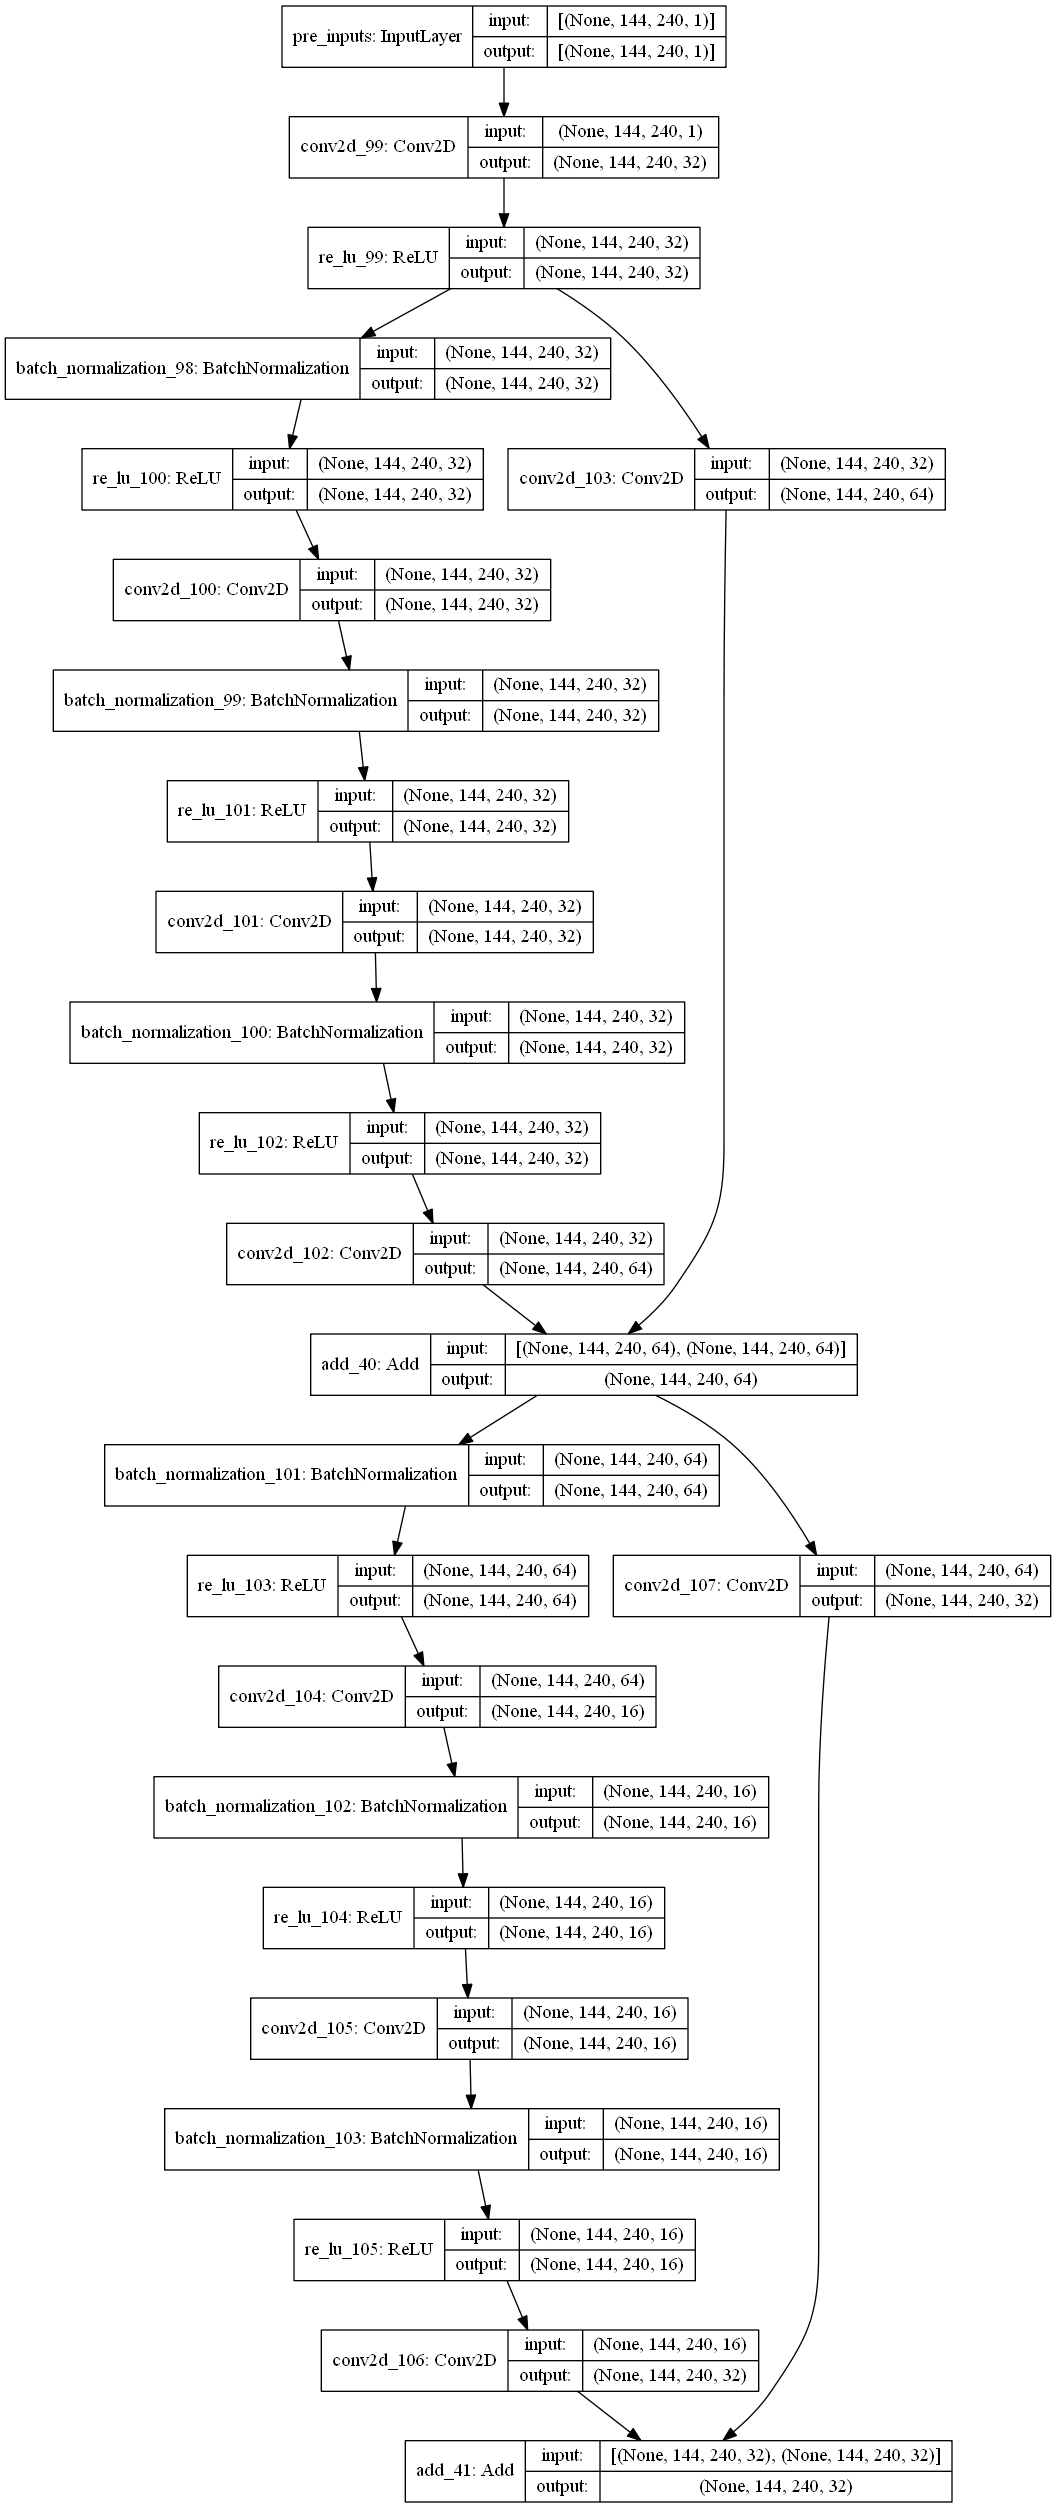

In [48]:
keras.utils.plot_model(pre_img, "pre_img.png", show_shapes=True)

# Stacked hourglass model and after process to get heatmaps

In [5]:
# Hourglass blocks
hg_inputs = Input(shape=(144, 240, 32), name='hg_inputs')
x_prev = hg_inputs
for i in range(_hg_num_modules):
    x = build_hg(x_prev, steps_to_go=4, num_features=_hg_num_feature_maps)
    # At last output do not merge.
    x, h = build_hg_after(
        x_prev, x, do_merge=(i < (_hg_num_modules - 1)),
    )
    x_prev = x
hg_outputs = h
stacked_hg_heatmaps = keras.Model(hg_inputs, hg_outputs, name='stacked_hg_heatmaps')

In [42]:
keras.utils.plot_model(stacked_hg_heatmaps, "stacked_hg_heatmaps.png", show_shapes=True)

# Untrainable layer for generating landmarks coordinates by heatmaps

In [6]:
# Soft-argmax for landmarks calculation
ldmks_layer = Lambda(cal_landmarks, name='ldmks_layer')

In [44]:
ldmks_layer

# Submodel for estimating eye ball radius by landmarks coordinates

In [7]:
# Fully-connected layers for radius regression
fc_inputs = Input(shape=(18, 2), name='fc_inputs')
x = tf.transpose(fc_inputs, perm=[0, 2, 1])
x = Flatten()(x)
for i in range(3):
    x = Dense(
        units=100,
        kernel_initializer=_kernel_initializer,
        kernel_regularizer=_kernel_regularizer,
        bias_initializer=_bias_initializer
    )(x)
    x = BatchNormalization(scale=True, center=True, trainable=True)(x)
    x = ReLU()(x)
fc_outputs = Dense(
    units=1,
    kernel_initializer=_kernel_initializer,
    kernel_regularizer=_kernel_regularizer,
    bias_initializer=_bias_initializer
)(x)
fc_radius = keras.Model(fc_inputs, fc_outputs, name='fc_radius')

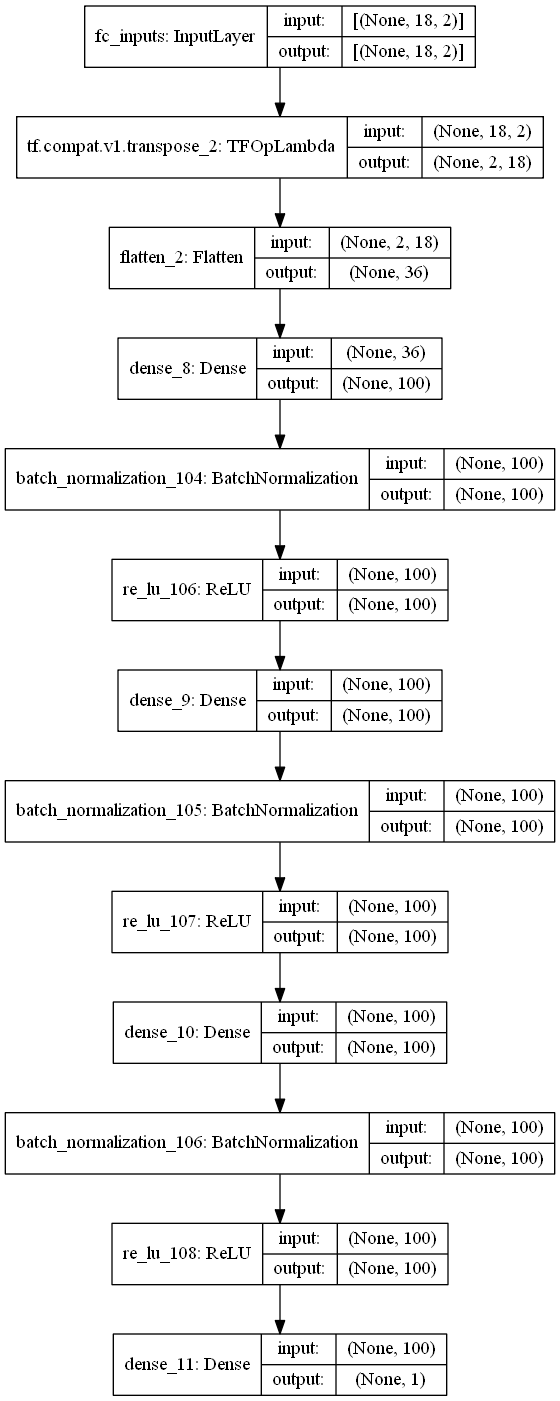

In [47]:
keras.utils.plot_model(fc_radius, "fc_radius.png", show_shapes=True)

# Summary all submodel for the entire ELG model

In [8]:
elg_inputs = Input(shape=(144, 240, 1), name='elg_inputs')
pre_input = pre_img(elg_inputs)
heatmaps = stacked_hg_heatmaps(pre_input)
ldmks = ldmks_layer(heatmaps)
radius = fc_radius(ldmks)
elg_heatmaps = keras.Model(elg_inputs, heatmaps, name='elg_heatmaps')
elg_ldmks = keras.Model(elg_inputs, ldmks, name='elg_ldmks')
elg_radius = keras.Model(elg_inputs, radius, name='elg_radius')

Model: "elg_heatmaps"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elg_inputs (InputLayer)      [(None, 144, 240, 1)]     0         
_________________________________________________________________
pre_img (Functional)         (None, 144, 240, 32)      22880     
_________________________________________________________________
stacked_hg_heatmaps (Functio (None, 144, 240, 18)      107364    
Total params: 130,244
Trainable params: 126,148
Non-trainable params: 4,096
_________________________________________________________________


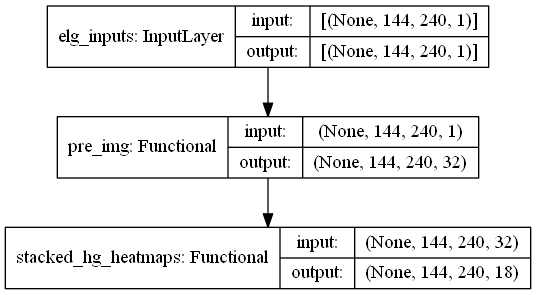

In [37]:
elg_heatmaps.summary()
keras.utils.plot_model(elg_heatmaps, "elg_heatmaps.png", show_shapes=True)

Model: "elg_ldmks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elg_inputs (InputLayer)      [(None, 144, 240, 1)]     0         
_________________________________________________________________
pre_img (Functional)         (None, 144, 240, 32)      22880     
_________________________________________________________________
stacked_hg_heatmaps (Functio (None, 144, 240, 18)      107364    
_________________________________________________________________
ldmks_layer (Lambda)         (None, 18, 2)             0         
Total params: 130,244
Trainable params: 126,148
Non-trainable params: 4,096
_________________________________________________________________


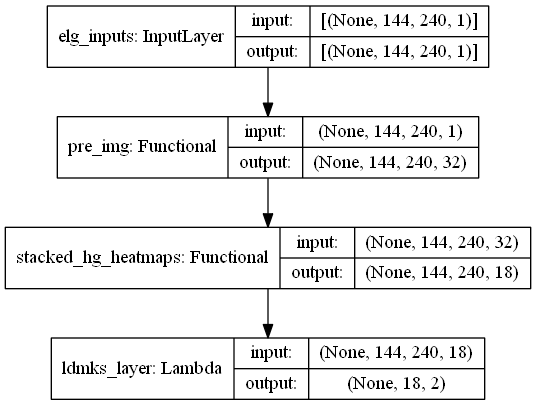

In [38]:
elg_ldmks.summary()
keras.utils.plot_model(elg_ldmks, "elg_ldmks.png", show_shapes=True)

Model: "elg_radius"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
elg_inputs (InputLayer)      [(None, 144, 240, 1)]     0         
_________________________________________________________________
pre_img (Functional)         (None, 144, 240, 32)      22880     
_________________________________________________________________
stacked_hg_heatmaps (Functio (None, 144, 240, 18)      107364    
_________________________________________________________________
ldmks_layer (Lambda)         (None, 18, 2)             0         
_________________________________________________________________
fc_radius (Functional)       (None, 1)                 25201     
Total params: 155,445
Trainable params: 150,749
Non-trainable params: 4,696
_________________________________________________________________


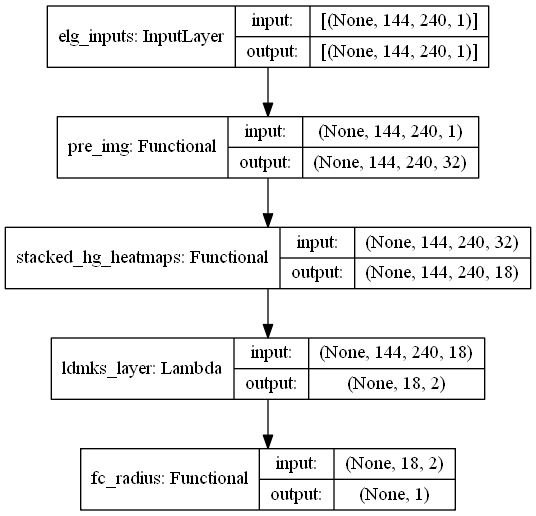

In [39]:
elg_radius.summary()
keras.utils.plot_model(elg_radius, "elg_radius.png", show_shapes=True)

# Test if the image can go through this model

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import cv2 as cv

In [10]:
from src.datasources import unityeyes

u = unityeyes.UnityEyes(unityeyes_path='E:/Datasets/UnityEyes_Windows/imgs', testing=True, generate_heatmaps=True)

In [23]:
entry = next(u.entry_generator())

In [24]:
entry

{'radius': 61.34844,
 'gaze': array([-0.12268021,  0.6945073 ], dtype=float32),
 'eye': array([[[-0.64705884],
         [-0.64705884],
         [-0.64705884],
         ...,
         [ 0.3803922 ],
         [ 0.35686278],
         [ 0.3411765 ]],
 
        [[-0.64705884],
         [-0.64705884],
         [-0.64705884],
         ...,
         [ 0.4039216 ],
         [ 0.3803922 ],
         [ 0.3803922 ]],
 
        [[-0.64705884],
         [-0.64705884],
         [-0.6313726 ],
         ...,
         [ 0.4039216 ],
         [ 0.4039216 ],
         [ 0.3803922 ]],
 
        ...,
 
        [[ 0.992157  ],
         [ 0.992157  ],
         [ 0.98431385],
         ...,
         [ 0.9764707 ],
         [ 0.98431385],
         [ 0.98431385]],
 
        [[ 0.98431385],
         [ 0.98431385],
         [ 0.9764707 ],
         ...,
         [ 0.9764707 ],
         [ 0.98431385],
         [ 0.98431385]],
 
        [[ 0.98431385],
         [ 0.9764707 ],
         [ 0.9764707 ],
         ...,
       

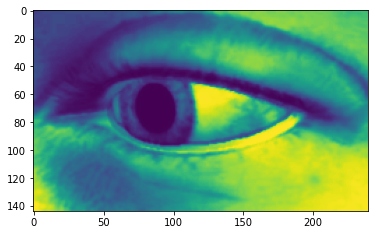

In [25]:
plt.imshow(entry['eye'])

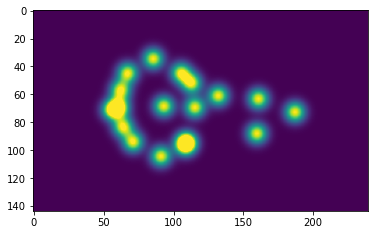

In [26]:
plt.imshow(np.sum(entry['heatmaps'], axis=-1), vmin=0, vmax=1)

In [29]:
elg_inputs = tf.expand_dims(entry['eye'], axis=0)

In [31]:
heatmaps = elg_heatmaps(elg_inputs)

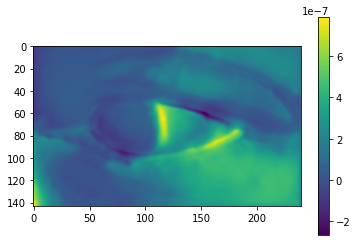

In [37]:
plt.imshow(tf.math.reduce_sum(heatmaps, axis=-1)[0])
plt.colorbar()

In [34]:
landmarks = elg_ldmks(elg_inputs)

In [35]:
landmarks

<tf.Tensor: shape=(1, 18, 2), dtype=float32, numpy=
array([[[120.00027 ,  72.00013 ],
        [120.00028 ,  72.000145],
        [120.0002  ,  72.0001  ],
        [119.99982 ,  71.999886],
        [120.00013 ,  72.00008 ],
        [120.000114,  72.00006 ],
        [120.000046,  72.00003 ],
        [120.00017 ,  72.00007 ],
        [119.999756,  71.99989 ],
        [120.0003  ,  72.0001  ],
        [119.99986 ,  71.99992 ],
        [120.000084,  71.999985],
        [119.99977 ,  71.99993 ],
        [120.00013 ,  72.00006 ],
        [119.99995 ,  71.999954],
        [119.99973 ,  71.99987 ],
        [119.99982 ,  71.99995 ],
        [120.00003 ,  71.99998 ]]], dtype=float32)>

In [38]:
radius = elg_radius(elg_inputs)

In [41]:
radius

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00052361]], dtype=float32)>

In [1]:
import src.models.elg as elg

In [2]:
elg_builder = elg.ELGBuilder()

In [3]:
elg_heatmaps, elg_ldmks, fc_radius, fc_gaze = elg_builder.build_model()

In [4]:
fc_gaze.summary()

Model: "fc_radius"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_gaze_inputs_ldmks (InputL [(None, 1, 37)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 50)             1900      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 100)            5100      
_________________________________________________________________
batch_normalization_138 (Bat (None, 1, 100)            400       
_________________________________________________________________
re_lu_139 (ReLU)             (None, 1, 100)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 100)            10100     
_________________________________________________________________
batch_normalization_139 (Bat (None, 1, 100)            40

# Test a trained model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import src.models.elg as elg
import src.datasources.unityeyes as unityeyes
import src.utils.gaze as gaze_util

In [2]:
elg_builder = elg.ELGBuilder()

In [3]:
_, elg_ldmks, elg_radius, elg_gaze = elg_builder.build_model()

In [4]:
u_data = unityeyes.UnityEyes(unityeyes_path='E:/Datasets/UnityEyes_Windows/imgs')

In [5]:
checkpoint_ldmks = './models/elg_ldmks/model-v0.0.1-epoch-73-loss-5.9328.h5'
checkpoint_radius = './models/elg_radius/model-v0.0.1-epoch-100-loss-0.0016.h5'
checkpoint_gaze = './models/elg_gaze/model-v0.0.1-epoch-99-loss-0.0000.h5'

In [6]:
elg_ldmks.load_weights(checkpoint_ldmks)
elg_radius.load_weights(checkpoint_radius)
elg_gaze.load_weights(checkpoint_gaze)

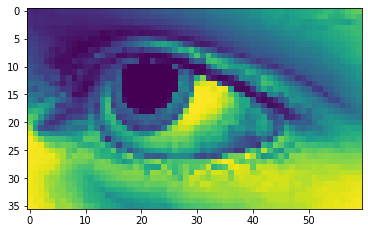

In [37]:
entry = next(u_data.entry_generator())
input_img = entry['eye']
plt.imshow(input_img)

In [38]:
input_img = tf.expand_dims(input_img, axis=0)

In [39]:
ldmks = elg_ldmks(input_img)

In [40]:
print(abs(ldmks - entry['landmarks']))

tf.Tensor(
[[[0.20956898 0.7919426 ]
  [0.41354084 0.15290165]
  [0.7292366  0.19346714]
  [0.57564926 0.03699112]
  [0.24308777 0.3960495 ]
  [0.95414734 0.3674965 ]
  [0.12407303 0.2859249 ]
  [0.21575737 0.49500847]
  [0.16101837 0.5811205 ]
  [0.23683739 0.21203947]
  [0.17674255 0.10070109]
  [0.08403206 0.14637136]
  [0.07712364 0.10476589]
  [0.19491005 0.10582924]
  [0.23820114 0.22042847]
  [0.04157448 0.23657608]
  [0.13269234 0.33893394]
  [0.00620651 0.7131882 ]]], shape=(1, 18, 2), dtype=float32)


In [41]:
ldmks_array = tf.reshape(ldmks, (18, 2))
ldmks_array.numpy()

array([[12.308054 , 18.88397  ],
       [14.157998 , 12.237992 ],
       [26.815823 ,  9.966428 ],
       [39.77629  , 16.25238  ],
       [46.014282 , 21.007746 ],
       [39.515488 , 24.748196 ],
       [26.315582 , 26.830238 ],
       [15.182998 , 23.42141  ],
       [14.697748 , 11.296171 ],
       [18.401785 ,  5.522807 ],
       [23.90446  ,  3.8512423],
       [28.735752 ,  7.2330914],
       [29.68206  , 13.893868 ],
       [25.781809 , 19.82572  ],
       [19.822285 , 21.695425 ],
       [15.280309 , 18.343098 ],
       [23.298063 , 12.939737 ],
       [32.011864 , 16.171349 ]], dtype=float32)

In [42]:
radius = elg_radius(ldmks)

In [43]:
print(abs(radius - entry['radius']))

tf.Tensor([[0.20470524]], shape=(1, 1), dtype=float32)


In [44]:
ldmks = tf.transpose(ldmks, perm=[0, 2, 1])
ldmks = tf.keras.layers.Flatten()(ldmks)
input_tensor = tf.keras.layers.Concatenate()([ldmks, radius])

In [45]:
gaze = elg_gaze(input_tensor)

In [46]:
print(abs(gaze - entry['gaze']))

tf.Tensor([[0.03504165 0.02237034]], shape=(1, 2), dtype=float32)


In [47]:
pitchyaw = tf.reshape(gaze, (2,))
pitchyaw.numpy()

array([0.19345665, 0.5843224 ], dtype=float32)

In [48]:
image_in = entry['eye']

In [49]:
image_out = gaze_util.draw_gaze(image_in, entry['landmarks'][-2], entry['gaze'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


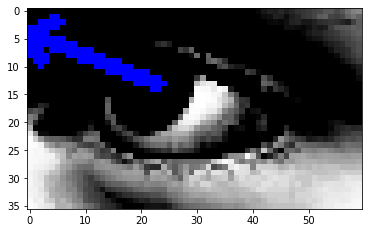

In [50]:
plt.imshow(image_out)

In [51]:
image_out = gaze_util.draw_gaze(image_in, ldmks_array[-2], pitchyaw.numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


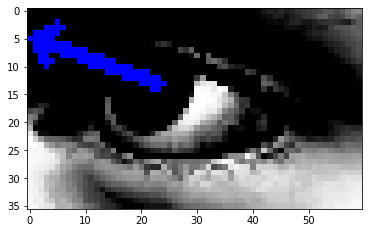

In [52]:
plt.imshow(image_out)